## RNN LSTM Text Classificaiton model

### Dependencies and Libraries

In [28]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('drive/MyDrive/School Work/CS4248/News Labelling Project')

### Reading in data into pd dataframes, data viewing

In [29]:
# Read CSV file in
train_path = './cleaned_data/clean_fulltrain.csv'
test_path = './cleaned_data/clean_balancedtest.csv'
df = pd.read_csv(train_path, header=None)

print(type(df))

# Samples, number of columns, 0 = labels, column 1 = text
print('Total rows, Total Columns: ' + str(df.shape))
df.sample(5) # Random sample values to see

<class 'pandas.core.frame.DataFrame'>
Total rows, Total Columns: (48854, 2)


,0,1
43837,4,two years acquitting former prime minister kos...
37314,3,un says radiation levels safe despite empirica...
9876,1,flight routing error hartsfield international ...
16809,2,watch donald trump call hillary clinton murder...
6738,1,according sources evanston resident danny vebb...


In [30]:
# Get number of labels for each task
classes = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']
label_numbers = [1,2,3,4]

for label in label_numbers:
    print(classes[label-1] + ': ' + str((df[0] == label).sum()))
print(df[0].value_counts())

Satire: 14047
Hoax: 6942
Propaganda: 17870
Reliable News: 9995
3    17870
1    14047
4     9995
2     6942
Name: 0, dtype: int64


### Reading in testing set

In [31]:
from sklearn.utils import shuffle
test_df = pd.read_csv(test_path, header=None)
test_df = shuffle(test_df)

test_df

,0,1
1930,3,labeling gmo foods good idea way getting accom...
2114,3,tweet newstarget influenced modern allopathic ...
1629,3,political correctness allowable thought approv...
894,2,new whistleblower leak exposes classified deta...
246,1,coca cola company ignited firestorm controvers...
...,...,...
1562,3,tweet newstarget conceivable massage provide e...
284,1,fox news channel reported today french voters ...
1616,3,food activist organization filed suit us depar...
398,1,ever since cleveland cavaliers lost nba finals...


In [32]:
# Get number of labels for each task
classes = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']
label_numbers = [1,2,3,4]

for label in label_numbers:
    print(classes[label-1] + ': ' + str((test_df[0] == label).sum()))
print(test_df[0].value_counts())

Satire: 750
Hoax: 750
Propaganda: 750
Reliable News: 750
3    750
2    750
1    750
4    750
Name: 0, dtype: int64


### Count number of unique words in the entire dataset

In [33]:
# Count number of unique words
def unique_word_counter(texts):
    count = Counter() # Dictionary type
    # Access an entire string
    for text in texts:
        # Split each string into individual words separated by whitespace
        for word in text.split():
            count[word] += 1
    return count

In [34]:
# Run counter
counts = unique_word_counter(df[1])
unique_words_count = len(counts)
print('Number of unique words: ' + str(unique_words_count))
print('Most Common Words:')
counts.most_common(10)

Number of unique words: 252019
Most Common Words:


[('said', 95152),
 ('us', 78350),
 ('one', 64372),
 ('would', 61931),
 ('people', 58751),
 ('government', 45594),
 ('like', 44459),
 ('new', 43537),
 ('time', 43174),
 ('also', 40434)]

### Prepare datasets, convert into numpy format for Keras Model

In [35]:
X_train = df[1].to_numpy()
y_train = df[0].to_numpy()

X_test = test_df[1].to_numpy()
y_test = test_df[0].to_numpy()

y_train = pd.get_dummies(df[0]).values
y_test = pd.get_dummies(test_df[0]).values
print(type(y_train))
print(type(y_test))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(48854,) (3000,)
(48854, 4) (3000, 4)


In [36]:
y_train

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [37]:
y_test

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]], dtype=uint8)

### Tokenise words into numbers
- Each word will be assigned a specific number, according to how many unique words we have
- Inspired from this [Youtube Video](https://www.youtube.com/watch?v=kxeyoyrf2cM&ab_channel=PythonEngineer)

In [38]:
# Each string is turned into a sequence of integers
tokenizer = Tokenizer(num_words=unique_words_count)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Pad sequences to a common length

In [39]:
# Determine minimum number of words in a sequence 65218, 

padding_length = 500

length_count = 0
for item in X_train:
    length = len(item)
    if length > padding_length:
        length_count += 1
print('Number of texts > word length: ' + str(length_count))

Number of texts > word length: 8672


In [40]:
X_train = pad_sequences(X_train, maxlen=padding_length, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=padding_length, padding="post", truncating="post")

# Ensure padded shape of dimension
X_train.shape, X_test.shape

((48854, 500), (3000, 500))

In [41]:
X_train.shape[1]

500

### Load model for evaluation

In [42]:
from tensorflow.python.client import device_lib
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
print(device_lib.list_local_devices())

No GPU found
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11664058203215459324
xla_global_id: -1
]


In [43]:
from keras.models import load_model
model = load_model('./TrainedModels/RNN_LSTM_clean_500pad_15.h5') # This is the better model

predictions = model.predict(X_test)

In [44]:
predictions

array([[1.57753821e-03, 1.02156936e-03, 9.95713115e-01, 1.68780296e-03],
       [6.74313706e-05, 9.53430135e-05, 9.99619961e-01, 2.17196910e-04],
       [3.23356576e-02, 1.02808429e-02, 8.32218766e-01, 1.25164732e-01],
       ...,
       [1.72695809e-03, 1.13033049e-03, 9.95231330e-01, 1.91142806e-03],
       [8.25284481e-01, 1.39110103e-01, 4.11851761e-05, 3.55641916e-02],
       [8.65914896e-02, 1.64461369e-03, 1.06048316e-01, 8.05715621e-01]],
      dtype=float32)

In [45]:
len(predictions)

3000

In [46]:
prediction_labels = []
for prediction in predictions:
    prediction_labels.append(np.argmax(prediction))
prediction_labels[0:10]

[2, 2, 2, 2, 0, 2, 0, 3, 0, 2]

In [47]:
actual_labels = []
for label in y_test:
    actual_labels.append(np.argmax(label))
actual_labels[0:10]

[2, 2, 2, 1, 0, 2, 2, 2, 0, 2]

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def score_model(predictions, target_value):
    score = f1_score(target_value, predictions, average='macro')
    print('F1 score = {}'.format(score))
    accuracy = accuracy_score(target_value, predictions)
    print('Accuracy = {}'.format(accuracy))
    precision = precision_score(target_value, predictions, average='micro')
    print('Precision = {}'.format(precision))
    print()

    # Print confusion matrix
def print_confusion_matrix(predictions, true_labels):
    cm = confusion_matrix(true_labels, predictions)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_plot.plot()

classes = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']

In [49]:
score_model(prediction_labels, actual_labels)

F1 score = 0.5417594088461987
Accuracy = 0.6126666666666667
Precision = 0.6126666666666667



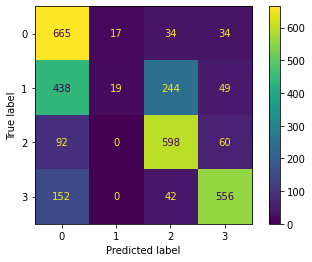

In [50]:
print_confusion_matrix(prediction_labels, actual_labels)

In [52]:
sequence_length = padding_length
vector_dimensions = 100
is_preprocessed_text = True

print('Sequence length: ' + str(sequence_length))
print('Embedding Vector Dimensions: ' + str(vector_dimensions))
print('Is clean text: ' + str(is_preprocessed_text))

Sequence length: 500
Embedding Vector Dimensions: 100
Is clean text: True
